In [1]:
import datetime
import math
from typing import Optional

import laspy
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa
import scipy as sp
import seaborn as sns
from tqdm import tqdm

In [2]:
plt.rcdefaults()

plt.style.use(["science",  # "grid",
               "ieee"])

plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["axes.prop_cycle"] = plt.rcParamsDefault["axes.prop_cycle"]

In [3]:
# Load the point cloud.
with laspy.open("lidar.laz") as src:
    data = src.read()

In [3]:
print(datetime.datetime.fromtimestamp(data["gps_time"][0] + 1315964800))

2020-03-17 02:26:58.010223


### Reflectance Field Rasterization

In [4]:
# Extract the necessary point attributes.
# NOTE: The elevation is used to estimate the surface normals.
ELEVATION = data["z"].scaled_array()

# REFLECTANCE = data["Reflectance"].scaled_array()
# # Convert the unit from dB to the underlying ratio.
# REFLECTANCE = (10 ** (0.1 * REFLECTANCE))
# # Clip erroneous values corresponding to non-Lambertian surfaces.
# REFLECTANCE = REFLECTANCE.clip(max=1)

In [5]:
# Compute the bounding box of the point cloud.
BBOX = [*data.header.mins[:2], *data.header.maxs[:2]]

# Specify the output raster resolution.
# NOTE: Use a sensible default resolution given the nominal AN4 point density (10 points/m^{2}) and BM5 imagery resolution (~8 cm - the actual resolution is 8 + 1.67e-8 cm, presumably due to floating-point rounding errors).
RESOLUTION: Optional[float] = None
if RESOLUTION is None:
    area = (BBOX[2] - BBOX[0]) * (BBOX[3] - BBOX[1])
    density = len(data) / area

    # NOTE: This is the "natural" resolution of the point cloud, assuming perfectly uniform point distribution in all directions.
    RESOLUTION = math.sqrt(density) ** -1
    # Do not exceed the BM5 resolution.
    RESOLUTION = max(RESOLUTION, 0.08)

RESOLUTION

# # Initialize the output raster.
# ras = raster.Raster(RESOLUTION, bbox=BBOX)
# 
# # Compute the raster cells.
# rows, cols = np.mgrid[0:ras.height, 0:ras.width]
# 
# cells_x = BBOX[0] + (cols + 0.5) * RESOLUTION
# cells_y = BBOX[3] - (rows + 0.5) * RESOLUTION
# 
# cells = np.vstack([cells_x.ravel(), cells_y.ravel()]).transpose()

0.163670261274894

In [13]:
# Initialize the spatial index of the point cloud.
index = sp.spatial.KDTree(np.vstack([data.x, data.y]).transpose())

### Surface Normal Vector Computation

In [17]:
# Compute the six nearest neighbors of each point.
# NOTE: Since the queries are the index itself, they are also returned as "neighbors" to themselves, and thus the seven instead of six nearest neighbors must actually be found.
k = 30
neighborhoods = index.query(index.data, k=k, distance_upper_bound=0.5, workers=-1)[1]

In [18]:
 # Fit a plane to the local neighborhood of each point.
normals = np.zeros([index.n, 3])
for i, neighborhood in tqdm(enumerate(neighborhoods),
                            desc="Normal Computation",
                            total=len(neighborhoods),
                            unit="points"):
    # Fetch the valid neighbors.
    # NOTE: See https://github.com/scipy/scipy/issues/3210 for more information.
    neighborhood_ids = neighborhood[neighborhood < len(index.data)]
    # Gather the local point neighborhood.
    neighborhood_pts = np.hstack([index.data[neighborhood_ids], ELEVATION[neighborhood_ids][:, None]])

    # Compute the relative point elevation of the neighborhood with respect to the corresponding query.
    # NOTE: The first point in the neighborhood is the seed, by convention.
    rel_elev = np.abs(neighborhood_pts[0, 2] - neighborhood_pts[:, 2])
    # Discard outliers from the neighborhood.
    # TODO: Fine tune the cutoff threshold.
    neighborhood_pts = neighborhood_pts[np.where(rel_elev < 0.1)]

    # TODO: Is this really necessary?
    if len(neighborhood_pts) < 3:
        # The neighborhood is erroneous.
        continue

    # NOTE: The final rotation matrix is returned in its Hermitian form.
    normal = np.linalg.svd(neighborhood_pts - np.mean(neighborhood_pts, axis=0))[-1][-1]
    if normal[-1] < 0:
        # The normal is pointing to the ground.
        normal *= -1

    normals[i] = normal

Normal Computation: 100%|██████████| 39233/39233 [00:01<00:00, 19734.04points/s]


In [9]:
# # Gather the point coordinates corresponding to the neighbors.
# normals = np.zeros([index.n, 3])
# 
# # Gather the local point neighborhoods.
# neighborhoods = np.concatenate((index.data[neighbors], ELEVATION[neighbors][..., None]), axis=2)
# 
# # Compute the relative elevation of each point in each neighborhood with 
# # respect to the corresponding query.
# # NOTE: The first point in the neighborhood is the query by convention.
# rel_elev = neighborhoods[..., 2][:, 0][:, None] - neighborhoods[..., 2]
# 
# # Find the valid points.
# # TODO: Fine tune this threshold.
# is_valid_pt = np.abs(rel_elev) <= 0.1
# # Find the valid neighborhoods.
# is_valid_neighborhood = np.sum(is_valid_pt, axis=1) >= 3
# # Discard the invalid neighborhoods.
# neighborhoods = np.array([neighborhoods[neighborhood, is_valid_pt[neighborhood], :] for neighborhood in
#                           tqdm(range(len(is_valid_neighborhood)), total=len(is_valid_neighborhood)) if
#                           is_valid_neighborhood[neighborhood]], dtype=np.object_)
# 
# # Estimate the normals.
# temp_normals = np.zeros((len(neighborhoods), 3))
# for i, neighborhood in tqdm(enumerate(neighborhoods), total=len(neighborhoods)):
#     if len(neighborhood) < 3:
#         continue
#     n = np.linalg.svd(neighborhood - np.mean(neighborhood, axis=0))[-1][-1]
#     if n[-1] < 0:
#         # The normal is pointing to the ground.
#         n *= -1
#     temp_normals[i] = n
# 
# normals[is_valid_neighborhood] = temp_normals

In [10]:
# from open3d.cpu.pybind.geometry import PointCloud
# import open3d as o3d
# 
# pcd:PointCloud = o3d.io.read_point_cloud("small.ply")
# pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.5, max_nn=30))
# pcd.orient_normals_to_align_with_direction([0,0,1])

In [11]:
np.save("lidar.norm", normals)

### Radiometric Calibration

In [5]:
normals = np.load("lidar.norm.npy")

In [6]:
# Get the scan angle.
# TODO: Explain the scan angle conversion.
# https://github.com/ASPRSorg/LAS/issues/41
scan_angle = np.radians(data.scan_angle * 0.006)

In [7]:
# Compute the refracted laser beam vectors.
# NOTE: This operation is the result of rotating the nadir-pointing ``k`` vector by the scan angle around the y-axis (i.e., the along-track direction), and then reversing its direction to point towards the sky.
refracted_beams = np.vstack([np.sin(scan_angle), np.zeros(len(scan_angle)), np.cos(scan_angle)]).transpose()

In [8]:
# NOTE: The beam vectors may not be normalized due to floating-point rounding errors, and thus the complete trigonometric calculation is necessary.
refraction_cosines = (refracted_beams * normals).sum(axis=1) / np.linalg.norm(refracted_beams, axis=1)

C:\Users\Dimit\AppData\Local\Temp\ipykernel_7064\1864194712.py:77: UserWarning: 
The palette list has fewer values (6) than needed (34) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x=bad_pts[:, 0],


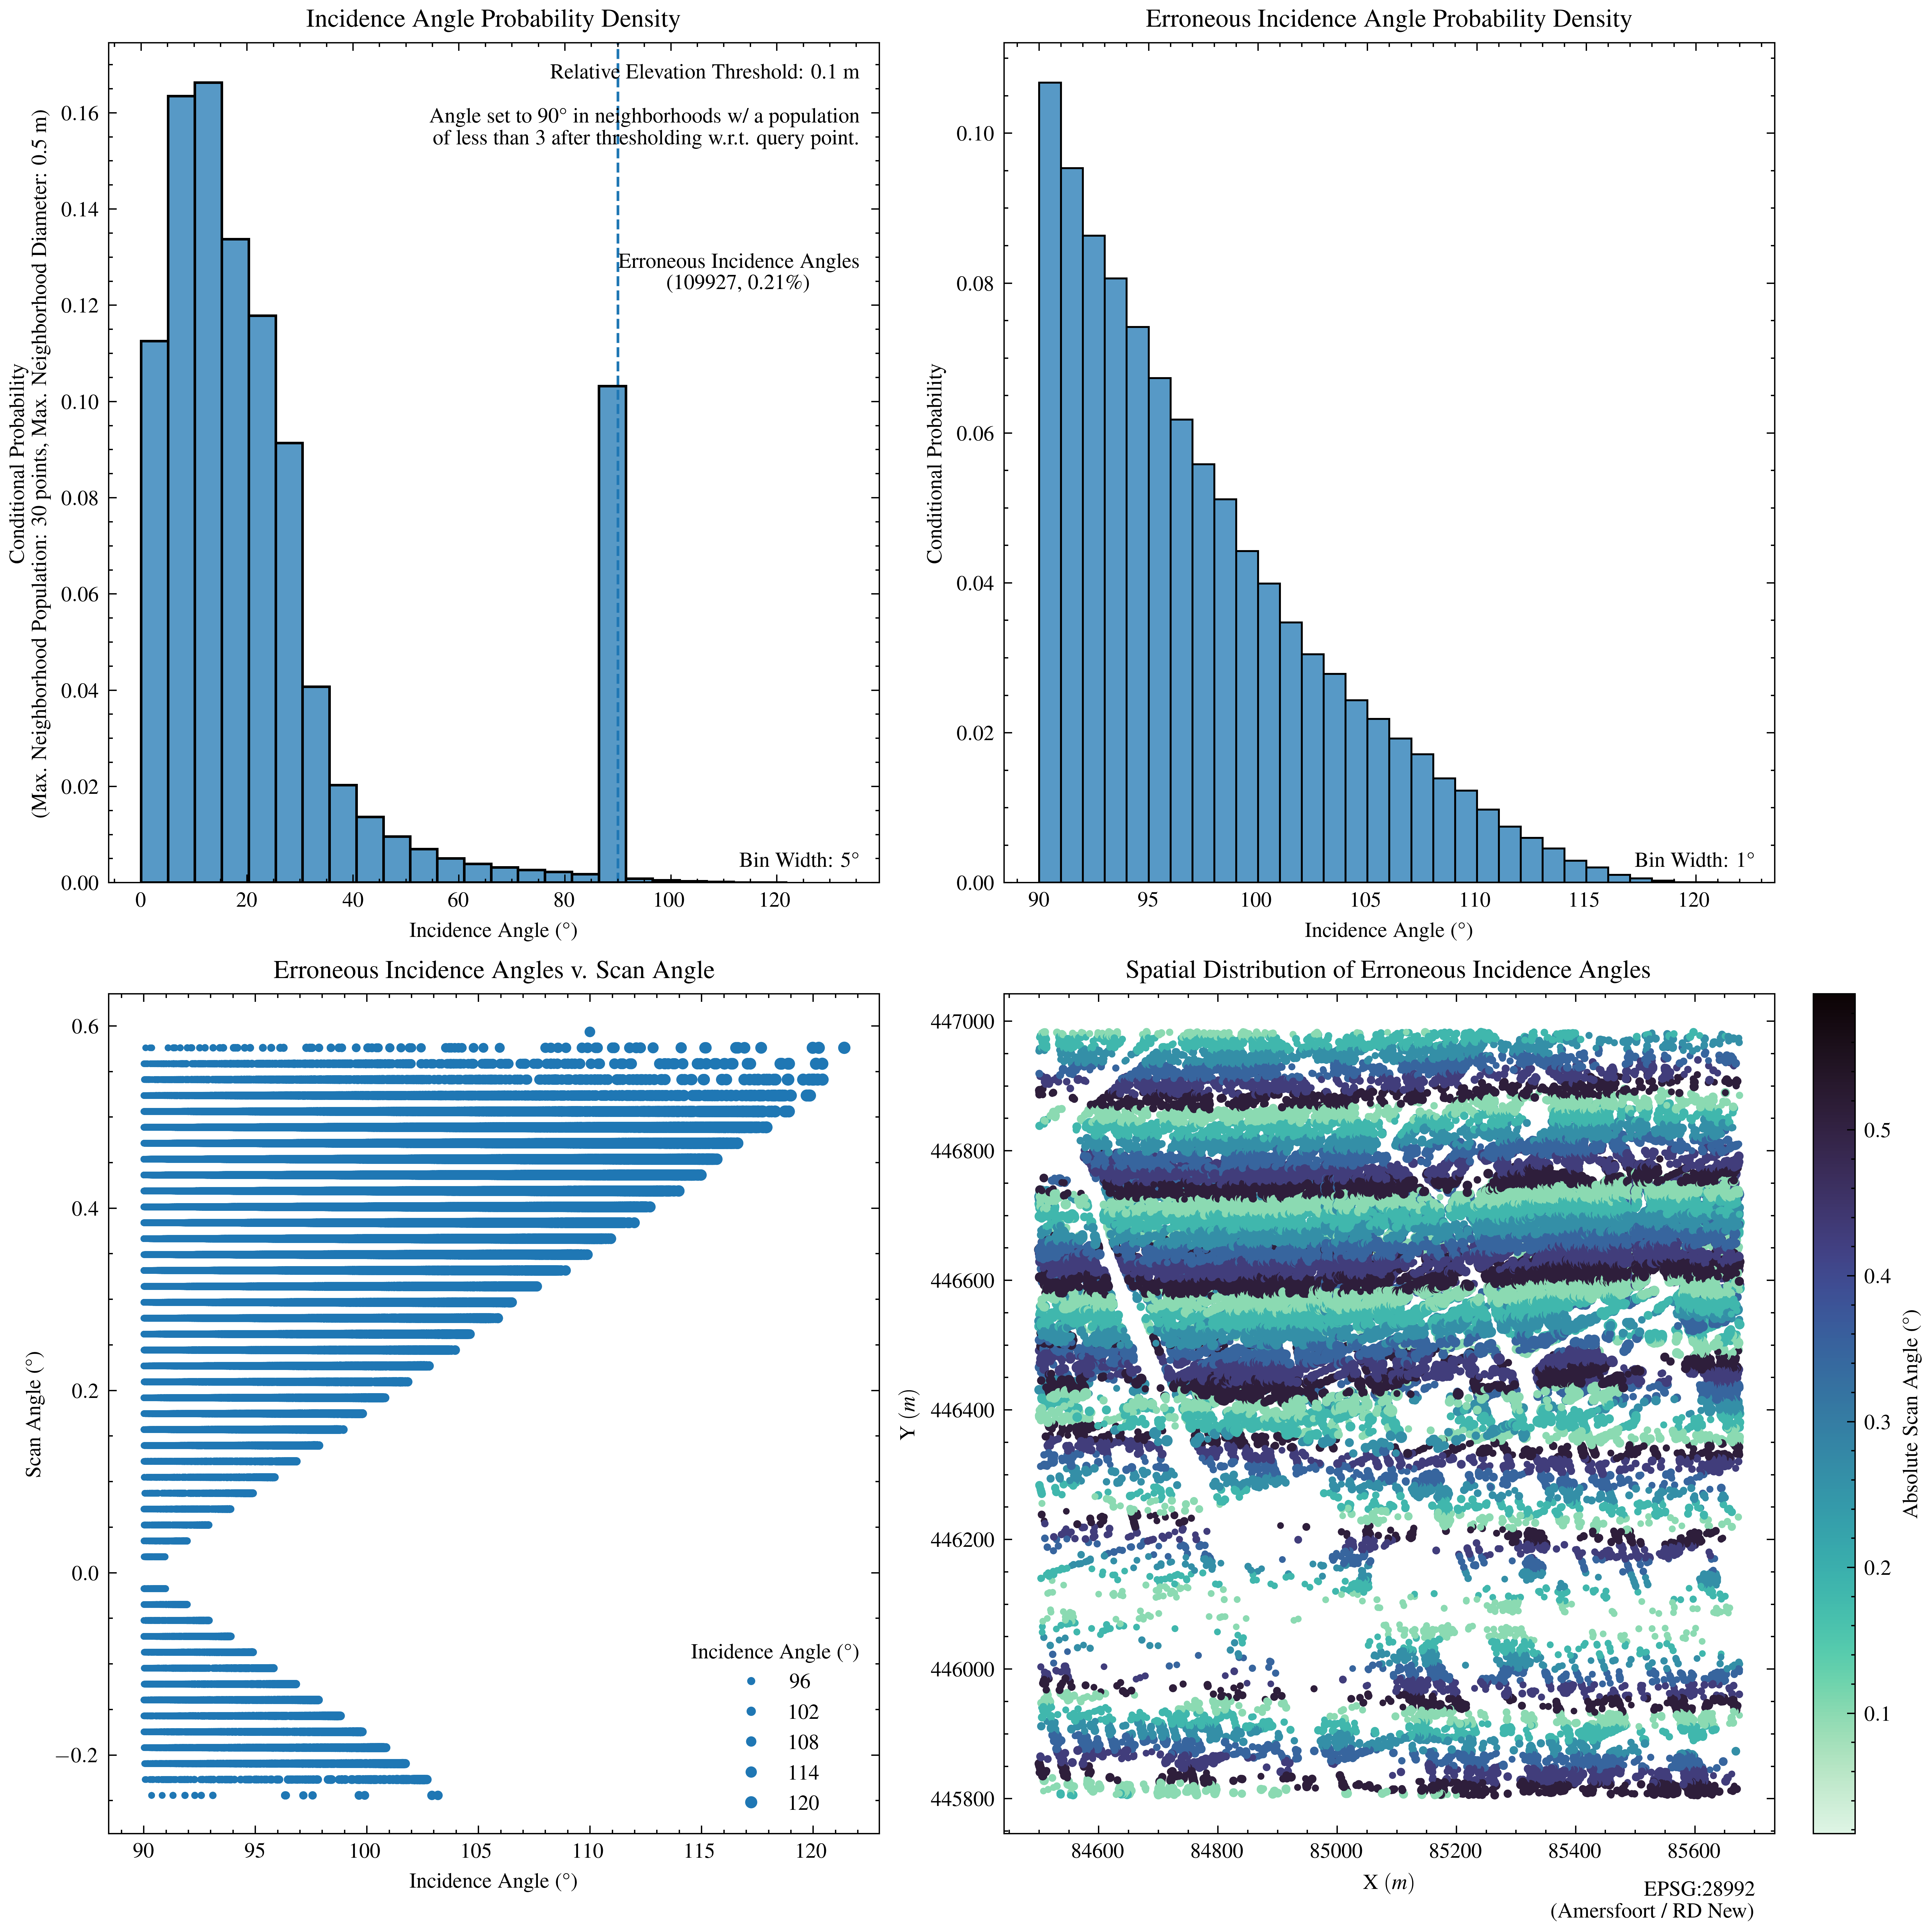

In [9]:
# Check the value quality.
bad_ids = refraction_cosines < 0

bad_cos = refraction_cosines[bad_ids]
bad_pts = data[bad_ids].xyz

# Count and report on the erroneous values.
# print(f"Found {len(bad_pts)} ({(len(bad_pts)/len(refraction_cosines)*100):.2f}% of the population) points associated with an erroneous refraction angle.")

fig, axs = plt.subplots(2, 2, layout="constrained", figsize=(10, 10),  # dpi=100
                        )

# Visualize the value distribution.
sns.histplot(np.degrees(np.arccos(refraction_cosines)),
             stat="probability",
             binwidth=5,
             binrange=(0, np.ceil(np.degrees(np.arccos(refraction_cosines)).max())),
             ax=axs[0, 0])
axs[0, 0].axvline(90, ls="--", zorder=-1)
axs[0, 0].set_title("Incidence Angle Probability Density")
axs[0, 0].set_xlabel('Incidence Angle (°)')
axs[0, 0].set_xlim((axs[0, 0].get_xlim()[0], axs[0, 0].get_xlim()[1] + 10 + 1.25))
# axs[0, 0].set_xticks(np.arange(0, np.ceil(np.degrees(np.arccos(refraction_cosines)).max()) + 5 / 2, 5 / 2),np.arange(0, np.ceil(np.degrees(np.arccos(refraction_cosines)).max()) + 5 / 2, 5 / 2))
axs[0, 0].set_ylabel(
    'Conditional Probability\n(Max. Neighborhood Population: 30 points, Max. Neighborhood Diameter: 0.5 m)')
axs[0, 0].text(1 - 0.025,
               1 - 0.025,
               "Relative Elevation Threshold: 0.1 m\n\nAngle set to 90° in neighborhoods w/ a population\nof less than 3 after thresholding w.r.t. query point.",
               ha='right',
               ma="right",
               va='top',
               transform=axs[0, 0].transAxes)
axs[0, 0].text(1 - 0.025,
               0.75,
               f"Erroneous Incidence Angles\n({len(bad_pts)}, {(len(bad_pts) / len(refraction_cosines) * 100):.2f}\%)",
               ha='right',
               ma="center",
               va='top',
               transform=axs[0, 0].transAxes)
axs[0, 0].text(1 - 0.025,
               0 + 0.025,
               "Bin Width: 5°",
               ha='right',
               ma="right",
               va='center',
               transform=axs[0, 0].transAxes)

sns.histplot(np.degrees(np.arccos(bad_cos)),
             stat="probability",
             binwidth=1,
             binrange=(np.floor(np.degrees(np.arccos(bad_cos)).min()), np.ceil(np.degrees(np.arccos(bad_cos)).max())),
             ax=axs[0, 1])
axs[0, 1].set_title(f"Erroneous Incidence Angle Probability Density")
axs[0, 1].set_xlabel('Incidence Angle (°)')
# axs[0, 1].set_xticks(np.arange(0, np.ceil(np.degrees(np.arccos(bad_cos)).max()) + 1 / 2, 1 / 2),np.arange(0, np.ceil(np.degrees(np.arccos(bad_cos)).max()) + 1 / 2, 1 / 2))
axs[0, 1].set_ylabel('Conditional Probability')
axs[0, 1].text(1 - 0.025,
               0 + 0.025,
               "Bin Width: 1°",
               ha='right',
               ma="right",
               va='center',
               transform=axs[0, 1].transAxes)

plot = sns.scatterplot(x=np.degrees(np.arccos(bad_cos)),
                       y=scan_angle[bad_ids],
                       size=np.degrees(np.arccos(bad_cos)),
                       legend="brief",
                       ax=axs[1, 0],
                       marker='.',
                       edgecolor=None)
plot.legend().set_title('Incidence Angle (°)')
axs[1, 0].set_title("Erroneous Incidence Angles v. Scan Angle")
axs[1, 0].set_xlabel('Incidence Angle (°)')
axs[1, 0].set_ylabel('Scan Angle (°)')

sns.scatterplot(x=bad_pts[:, 0],
                y=bad_pts[:, 1],
                hue=np.abs(scan_angle[bad_ids]),
                size=np.degrees(np.arccos(bad_cos)),
                palette=sns.color_palette("mako_r"),
                legend=False,
                ax=axs[1, 1],
                marker='.',
                edgecolor=None)
plt.colorbar(plt.cm.ScalarMappable(cmap="mako_r",
                                   norm=plt.Normalize(np.abs(scan_angle[bad_ids]).min(),
                                                      np.abs(scan_angle[bad_ids]).max())),
             ax=axs[1, 1],
             label="Absolute Scan Angle (°)")
axs[1, 1].set_title("Spatial Distribution of Erroneous Incidence Angles")
axs[1, 1].set_xlabel(r'X $\left(m\right)$')
axs[1, 1].set_ylabel(r'Y $\left(m\right)$')
axs[1, 1].text(1 - 0.025,
               0 - 3.25 * 0.025,
               "EPSG:28992\n(Amersfoort / RD New)",
               ha='right',
               ma="right",
               va='center',
               transform=axs[1, 1].transAxes)

fig.savefig("normals.pdf")